# 이베스트투자증권 거래내역 및 계좌잔고 조회

## 준비작업

### 1. 아래 버튼을 눌러 Notebook을 Colab에서 엽니다.

<a target="_blank" href="https://colab.research.google.com/github/pyqqq-team/samples/blob/main/notebooks/ebest_account.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### 2. 개인 보안 정보를 입력하세요

데이터를 조회하기 위해 필요한 아래 정보들을 채워 넣습니다.
- `app_key`: 이베스트투자증권 OpenAPI 포털에서 발행한 App key
- `app_secret`: 이베스트투자증권 OpenAPI 포털에서 발행한 App secret

    >**Tip!**
    >
    >위의 개인 보안 정보들을 채워 넣은 후 `CTRL-F9` (Windows) or `⌘-F9` (Mac)를 눌러 전체 노트북을 다시 시작 할 수 있습니다..


In [ ]:
%pip install pyqqq

app_key = '<이베스트투자증권_OPENAPI_APP_KEY>'
app_secret = '<이베스트투자증권_OPENAPI_APP_SECRET>'

In [9]:
from pyqqq.brokerage.ebest.oauth import EBestAuth
from pyqqq.brokerage.ebest.simple import EBestSimpleDomesticStock
from pyqqq.data.daily import get_all_ohlcv_for_date
from pyqqq.data.domestic import get_tickers
from pyqqq.utils.display import display
from pyqqq.utils.market_schedule import get_last_trading_day
import datetime as dtm
import dotenv
import os
import pandas as pd

dotenv.load_dotenv(".env.sample")


app_key = os.getenv("EBEST_APP_KEY")
app_secret = os.getenv("EBEST_APP_SECRET")

auth = EBestAuth(app_key, app_secret)
simple_api = EBestSimpleDomesticStock(auth)
stock_api = simple_api.stock_api

In [10]:
# @title 보유 주식 잔고 조회
def get_balance(include_sold=False):

    r = stock_api.get_stock_balance()

    output1 = r['output1']
    output2 = r['output2']

    purchase_amount = output1["mamt"]
    current_amount = output1["tappamt"]
    pnl = output1["tdtsunik"]
    pnl_rate = round(int(pnl) / int(purchase_amount) * 100 if purchase_amount > 0 else 0, 2)

    statistics = {
        "purchase_amount": purchase_amount,
        "current_amount": current_amount,
        "pnl": pnl,
        "pnl_rate": pnl_rate,
    }

    positions = []
    asset_codes = []

    for data in output2:
        holding_qty = int(data["janqty"])
        if not include_sold and holding_qty == 0:
            continue

        asset_codes.append(data["expcode"])
        positions.append(
            {
                "code": data["expcode"],
                "name": data["hname"],
                "pnl": data["dtsunik"],
                "pnl_rate": data["sunikrt"],
                "holding_qty": holding_qty,
                "current_value": data["appamt"],
                "average_purchase_price": round(data["pamt"], 2),
                "purchase_value": data["mamt"],
                "current_price": data["price"],
            }
        )

    last_trading_day = get_last_trading_day()
    lastday_ohlcv = get_all_ohlcv_for_date(last_trading_day)
    for p in positions:
        lastday_price = lastday_ohlcv.loc[p["code"]]["close"]
        p["lastday_price_diff"] = str(round(int(p["current_price"] - lastday_price) / lastday_price * 100, 2))


    positions_df = pd.DataFrame(positions)
    if len(positions) > 0:
        positions_df = positions_df.sort_values(by="pnl_rate", ascending=False)
        positions_df.rename(columns={
            "code": "종목코드",
            "name": "종목명",
            "pnl": "평가손익",
            "pnl_rate": "수익률",
            "holding_qty": "보유수량",
            "current_value": "평가금액",
            "average_purchase_price": "매입단가",
            "purchase_value": "매입금액",
            "current_price": "현재가",
            "lastday_price_diff": "전일대비",
        }, inplace=True)
        positions_df.set_index("종목코드", inplace=True)

    net_df = pd.DataFrame([statistics])
    net_df.rename(index={0: "총합"}, inplace=True)
    net_df.rename(columns={
        "purchase_amount": "매입금액",
        "current_amount": "평가금액",
        "pnl": "평가손익",
        "pnl_rate": "수익률",
    }, inplace=True)

    return positions_df, net_df

positions_df, net_df = get_balance()

display(net_df)

if positions_df.size:
    def make_clickable(val):
        return f'<a href="https://finance.naver.com/item/main.nhn?code={val}">{val}</a>'
    html_positions_df = positions_df.style.format_index(make_clickable, axis=0)
    display(html_positions_df)
else:
    print("보유 중인 주식이 없습니다")

,매입금액,평가금액,평가손익,수익률
총합,1237918,1360675,122757,9.92


,종목명,평가손익,수익률,보유수량,평가금액,매입단가,매입금액,현재가,전일대비
종목코드,,,,,,,,,
319640,TIGER 골드선물(H),59321,15.00,28,454720,14121,395399,16240,2.36
360750,TIGER 미국S&P500,55356,14.06,25,448875,15740,393519,17955,0.25
305080,TIGER 미국채10년선물,8080,1.79,39,457080,11512,449000,11720,-0.38


In [11]:
#@title 매매손익
def get_today_pnl_and_trades():

    trades = []
    fetching = True
    asset_codes = set()

    tr_cont = "N"
    tr_cont_key = ""
    cts_medosu = ""
    cts_expcode = ""
    cts_price = ""
    cts_middiv = ""

    tickers = get_tickers()

    while fetching:
        r = stock_api.get_today_pnl_and_trades(tr_cont, tr_cont_key, cts_medosu, cts_expcode, cts_price, cts_middiv)

        for data in r['output2']:
            if data["medosu"] == "종목소계":
                continue

            code = data["expcode"]

            row = {
                "매매구분": data["medosu"],
                "종목코드": code,
                "종목명": tickers.loc[code, 'name'],
                "수량": data["qty"],
                "단가": data["price"],
                "약정금액": data["amt"],
                "수수료": data["fee"],
                "거래세": data["tax"],
                "농특세": data["argtax"],
                "정산금액": data["adjamt"],
                "매체": data["middiv"],
            }

            trades.append(row)
            asset_codes.add(code)

        if r["tr_cont"] == 'Y':
            output1 = r['output1']
            tr_cont_key = r['tr_cont_key']
            cts_medosu = output1['cts_medosu']
            cts_expcode = output1['cts_expcode']
            cts_price = output1['cts_price']
            cts_middiv = output1['cts_middiv']
        else:
            fetching = False

    if asset_codes:
        current_prices_df = simple_api.get_price_for_multiple_stock(list(asset_codes))

    if trades:
        trades_df = pd.DataFrame(trades)
        trades_df.set_index("종목코드", inplace=True)

        for code in asset_codes:
            trades_df.loc[code, "현재가"] = str(current_prices_df.loc[code, "current_price"])
    else:
        trades_df = pd.DataFrame()

    output1 = r['output1']
    cols = ["매매구분", "수량", "약정금액", "수수료", "거래세", "농특세", "제비용합", "정산금액"]
    rows = [
        ["매도", output1["mdqty"], output1["mdamt"], output1["mdfee"], output1["mdtax"], output1["mdargtax"], output1["tmdtax"], output1["mdadjamt"]],
        ["매수", output1["msqty"], output1["msamt"], output1["msfee"], "", "", output1["tmstax"], output1["msadjamt"]],
        ["합계", output1["tqty"], output1["tamt"], output1["tfee"], output1["ttax"], output1["targtax"], output1["ttax"], output1["tadjamt"]],
    ]
    net_df = pd.DataFrame(rows, columns=cols)
    net_df.set_index("매매구분", inplace=True)

    return trades_df, net_df

trades_df, net_df = get_today_pnl_and_trades()

display(net_df)
display(trades_df) if trades_df.size else "오늘의 매매가 없습니다"

,수량,약정금액,수수료,거래세,농특세,제비용합,정산금액
매매구분,,,,,,,
매도,1,17955,2,0,0,2,17953
매수,1,11740,1,,,1,11741
합계,2,29695,3,3,0,3,6212


,매매구분,종목명,수량,단가,약정금액,수수료,거래세,농특세,정산금액,매체,현재가
종목코드,,,,,,,,,,,
360750,매도,TIGER 미국S&P500,1,17955,17955,0,0,0,17955,OPEN API,17955
305080,매수,TIGER 미국채10년선물,1,11740,11740,0,0,0,11740,OPEN API,11720


In [12]:
#@title 주문 내역
def get_order_history(target_date: dtm.date=None):
    orders = []
    fetching = True
    cts_ordno = ""
    tr_cont_key = ""
    tickers = get_tickers()

    hoga_type_map = {
        '00': '지정가',
        '03': '시장가',
    }

    while fetching:
        r = stock_api.get_order_list(cts_ordno=cts_ordno, tr_cont_key=tr_cont_key)

        for data in r['output2']:
            code = data["expcode"]
            row = {
                "종목코드": code,
                "종목명": tickers.loc[code, "name"],
                "주문량": data["qty"],
                "체결량": data["cheqty"],
                "주문단가": data["price"],
                "체결평균": data["cheprice"],
                "총체결금액": data["cheprice"] * data["cheqty"],
                "구분": data["medosu"],
                "주문유형": hoga_type_map.get(data["hogagb"], data["hogagb"]),
                "미체결량": data["ordrem"],
                "취소수량": data["cfmqty"],
                "주문번호": data["ordno"],
                "원주문": data.get("orgnordno", ""),
                "주문시간": dtm.datetime.strptime(data["ordtime"], "%H%M%S%f").strftime('%H:%M:%S'),
                # "주문일": data["ord_dt"],
            }
            orders.append(row)

        if r["tr_cont"] == 'Y':
            cts_ordno = r['output1']['cts_ordno']
            tr_cont_key = r['tr_cont_key']
        else:
            fetching = False

    orders_df = pd.DataFrame(orders)
    orders_df.sort_values(by="주문시간", ascending=False, inplace=True)
    orders_df.set_index("종목코드", inplace=True)

    return orders_df

get_order_history()

,종목명,주문량,체결량,주문단가,체결평균,총체결금액,구분,주문유형,미체결량,취소수량,주문번호,원주문,주문시간
종목코드,,,,,,,,,,,,,
360750,TIGER 미국S&P500,1,1,0,17955,17955,매도,시장가,0,0,34685,,09:30:30
305080,TIGER 미국채10년선물,1,1,0,11740,11740,매수,시장가,0,0,34694,,09:30:30


In [13]:
#@title 기간 손익 익별 합산 조회
def get_period_profit(start_date: dtm.date, end_date: dtm.date, term="1"):

    fetching = True
    tr_cont_key = ''
    bucket = []

    while fetching:
        r = stock_api.get_period_profit(start_date, end_date, term, tr_cont_key)

        for data in r['output3']:
            bucket.append(data)

        if r["tr_cont"] == 'Y':
            tr_cont_key = r['tr_cont_key']
        else:
            fetching = False

    df = pd.DataFrame(bucket)

    if not df.empty:
        df.sort_values(by="BaseDt", inplace=True)

        # EvalPnlAmt 컬럼 값을 누적하는 새로운 컬럼을 만들어줍니다.
        df["누적실현손익"] = df["EvalPnlAmt"].cumsum()
        df.rename(
            columns={
                "BaseDt": "기간말일",
                "EvalPnlAmt": "투자수익",
                "TermErnrat": "수익률",
                "InvstAvrbalPramt": "투자원금평잔금액",
                "FdEvalAmt": "기초순자산",
                "EotEvalAmt": "기말순자산",
                "BnsctrAmt": "약정금액",
                "MnyinSecinAmt": "입금고액",
                "MnyoutSecoutAmt": "출금고액",
            },
            inplace=True,
        )

        df.set_index("기간말일", inplace=True)

    return df


end_date = (dtm.datetime.today() - dtm.timedelta(days=1)).date()
start_date = dtm.date(2024, 1, 1)

daily, weekly, monthly = [str(t) for t in range(1, 4)]

df = get_period_profit(start_date, end_date, weekly)
df

,기초순자산,기말순자산,투자원금평잔금액,약정금액,입금고액,출금고액,투자수익,수익률,Idx,누적실현손익
기간말일,,,,,,,,,,
20240106,1244698,1239458,1244698,0,0,0,-5240,-0.421,0.00,-5240
20240113,1239458,1245658,1239458,0,0,0,6200,0.500,0.00,960
20240120,1245658,1253767,1245658,29570,0,0,8109,0.651,0.00,9069
20240127,1253767,1260807,1253767,0,0,0,7040,0.562,0.00,16109
20240203,1260807,1267177,1260807,0,0,0,6370,0.505,0.00,22479
20240210,1267177,1266567,1267177,0,0,0,-610,-0.048,0.00,21869
20240217,1266567,1263187,1266567,0,0,0,-3380,-0.267,0.00,18489
20240224,1263187,1266360,1263187,16655,0,0,3173,0.251,0.00,21662
20240302,1266360,1270150,1266360,0,0,0,3790,0.299,0.00,25452


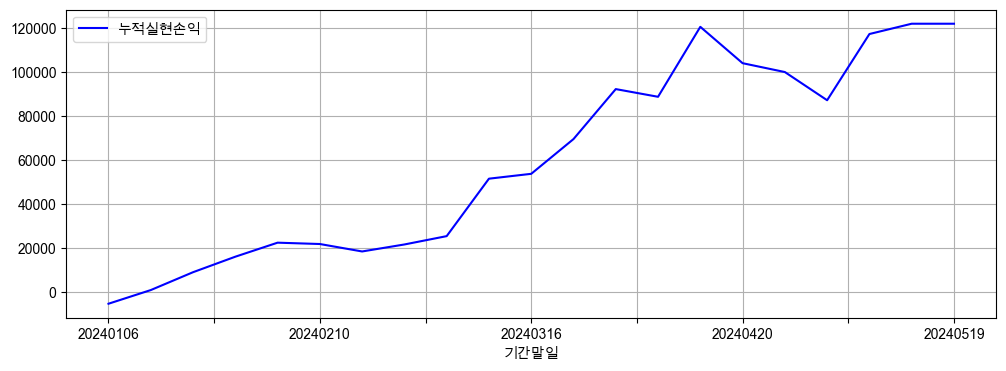

In [14]:
# @title 누적 실현 손익 차트

import matplotlib.pyplot as plt
from matplotlib import rc

df.index.names = ["Date"]
df.rename(columns={"누적실현손익": "Cumulative Realized PnL"}, inplace=True)
ax = df[["Cumulative Realized PnL"]].plot(figsize=(12, 4), style=["b-"])

plt.grid(True)
plt.show()